### 데이터 불러오기

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
SEED = 1030

In [3]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize((0.5,), (1.0,))
    ]
)

train_data = datasets.MNIST(root="./", train=True, download=True, transform=data_transform)
test_data = datasets.MNIST(root="./", train=False, download=True, transform=data_transform)


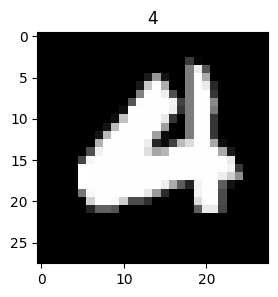

In [4]:
# 데이터 1개 그림 그리기
import matplotlib.pyplot as plt

idx = 1030
fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(train_data.data[idx], cmap="gray")
ax.set_title(train_data.targets[idx].item())
plt.show()

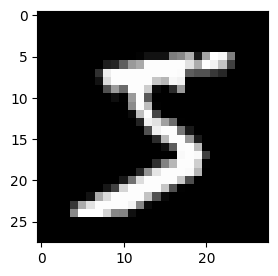

In [5]:
# 샘플 이미지
image = train_data.data[0] / 255.0  # 0~1 사이 값으로 표햔

fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(image, cmap="gray")
plt.show()


### 특성 추출 과정 확인

In [6]:
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        return x
        
    def extract_feature(self, x):
        print(f"x의 shape: {x.shape}")
        x1 = self.conv1(x)
        print(f"x1의 shape(conv1): {x1.shape}")
        x2 = self.relu(x1)
        print(f"x2의 shape(relu): {x2.shape}")
        x3 = self.pool(x2)
        print(f"x3의 shape(pool): {x3.shape}")
        x4 = self.conv2(x3)
        print(f"x4의 shape(conv2): {x4.shape}")
        
        outputs = [x1, x2, x3, x4]
        
        return outputs

model = SimpleCNN()
image2 = image.unsqueeze(0)
outputs = model.extract_feature(image2)

x의 shape: torch.Size([1, 28, 28])
x1의 shape(conv1): torch.Size([8, 28, 28])
x2의 shape(relu): torch.Size([8, 28, 28])
x3의 shape(pool): torch.Size([8, 14, 14])
x4의 shape(conv2): torch.Size([16, 14, 14])


torch.Size([8, 28, 28])


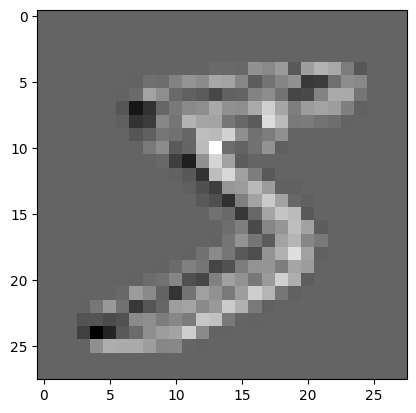

torch.Size([8, 28, 28])


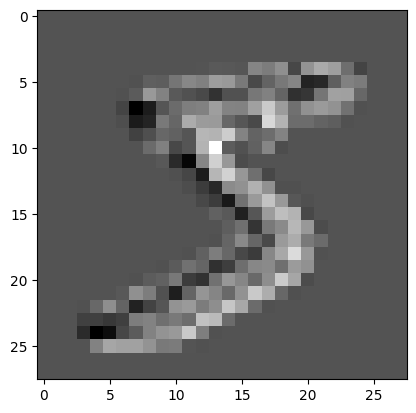

torch.Size([8, 14, 14])


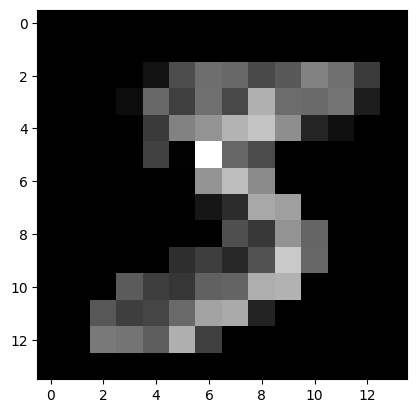

torch.Size([16, 14, 14])


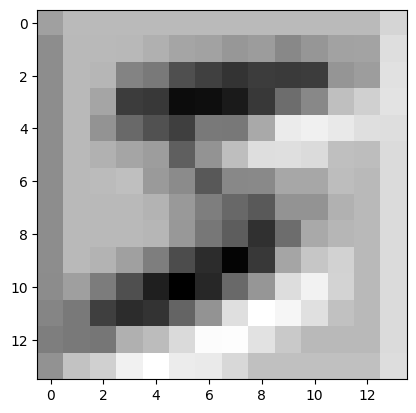

In [7]:
for o in outputs:
    print(o.shape)
    plt.imshow(o[0].detach().cpu().numpy(), cmap="gray")
    plt.show()

In [8]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
              ReLU-2            [-1, 8, 32, 32]               0
         MaxPool2d-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           1,168
Total params: 1,248
Trainable params: 1,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


### Lenet 5 구현

In [23]:
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)   # (1, 32, 32) → (6, 28, 28)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)  # (6, 14, 14) → (16, 10, 10)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # (16, 5, 5) → 120
        self.fc2 = nn.Linear(120, 84)          # 120 → 84
        self.fc3 = nn.Linear(84, 10)           # 84 → 10 (클래스 수)

        # Activation & Pooling
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 MaxPooling
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolution + ReLU + Pooling  (6, 28, 28) → (6, 14, 14)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Convolution + ReLU + Pooling  (16, 10, 10) → (16, 5, 5)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten (Batch, 16*5*5)
        x = x.view(-1, 16 * 5 * 5)

        # Fully Connected Layers
        x = self.fc1(x)  # 120
        x = self.relu(x)
        
        x = self.fc2(x)  # 84
        x = self.relu(x)
        
        x = self.fc3(x)  # 10 (Logits for classification)
        # x = self.softmax(x)

        return x
    
    def extract_feature(self, x):
        # Convolution + ReLU + Pooling  (6, 28, 28) → (6, 14, 14)
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x1 = self.pool(x1)
        
        # Convolution + ReLU + Pooling  (16, 10, 10) → (16, 5, 5)
        x2 = self.conv2(x1)
        x2 = self.relu(x2)
        x2 = self.pool(x2)
        
        outputs = [x1, x2]
        
        return outputs
    
    
model = LeNet5()
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [24]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {torch.cuda.get_device_name()}")
model = model.to(device)
summary(model, input_size=(1, 32, 32))

device: NVIDIA GeForce RTX 4070 Laptop GPU
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
------------------------------------------------------

In [25]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize((0.5,), (1.0,))
    ]
)

train_data = datasets.MNIST(root="./", train=True, download=True, transform=data_transform)
test_data = datasets.MNIST(root="./", train=False, download=True, transform=data_transform)

train_size = int(0.8 * len(train_data))   # 48,000개
val_size = len(train_data) - train_size   # 12,000개
train_dataset, val_dataset = random_split(
    train_data, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)  # 시드값 고정
)

print(f"train\tX: {len(train_dataset)}")
print(f"val\tX: {len(val_dataset)}")

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# 전체 데이터를 로드하여 Shape 확인
train_X, train_y = next(iter(train_loader))
val_X, val_y = next(iter(val_loader))
# test_X, test_y = next(iter(test_loader))

# # 채널 차원 제거
# train_X = train_X.squeeze()  # (48000, 32, 32)
# val_X = val_X.squeeze()      # (12000, 32, 32)
# # test_X = test_X.squeeze()    # (10000, 28, 28)

# 데이터셋 정보 출력
print(f"train\tX: {train_X.shape}, y: {train_y.shape}")
print(f"val\tX: {val_X.shape}, y: {val_y.shape}")
print(f"test\tX: {test_data.data.shape}, y: {test_data.targets.shape}")


train	X: 48000
val	X: 12000
train	X: torch.Size([32, 1, 32, 32]), y: torch.Size([32])
val	X: torch.Size([32, 1, 32, 32]), y: torch.Size([32])
test	X: torch.Size([10000, 28, 28]), y: torch.Size([10000])


Epoch: 0	Train Loss: 0.2355, Train Acc: 92.52% | Val Loss: 0.0866, Val Acc: 97.47%
모델 저장 완료: lenet5_0


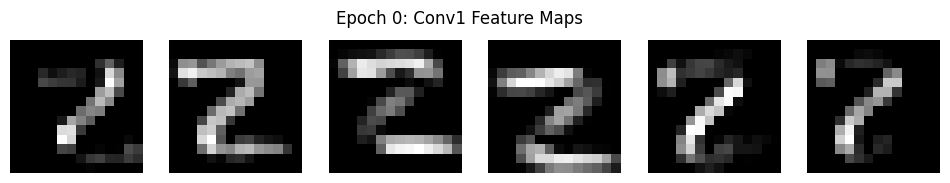

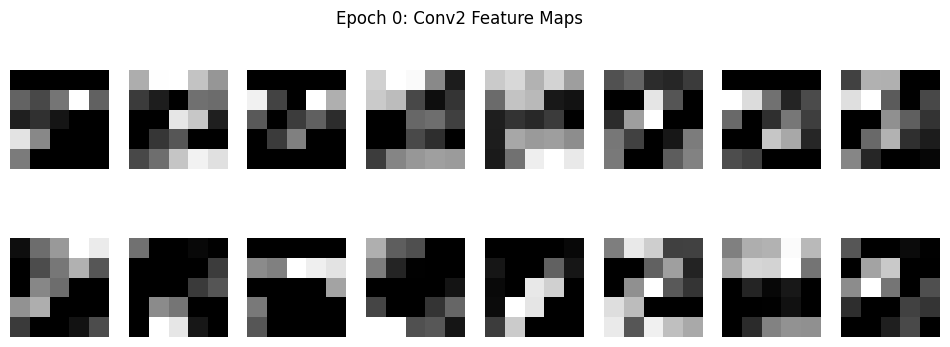

Epoch: 1	Train Loss: 0.0681, Train Acc: 97.83% | Val Loss: 0.0643, Val Acc: 97.99%


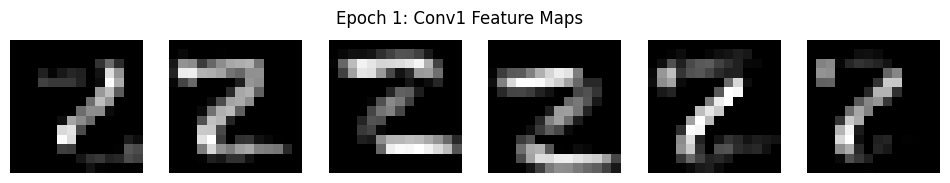

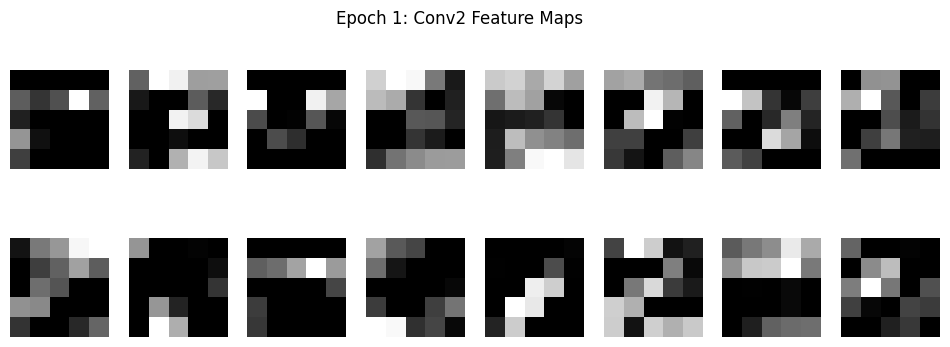

Epoch: 2	Train Loss: 0.0493, Train Acc: 98.42% | Val Loss: 0.0574, Val Acc: 98.22%


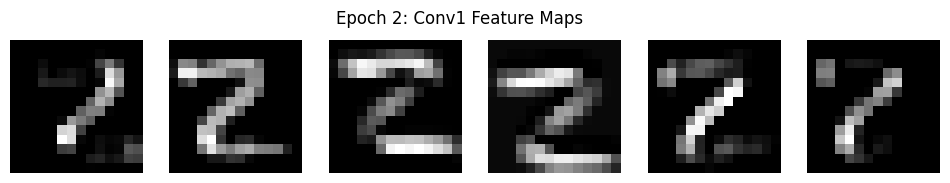

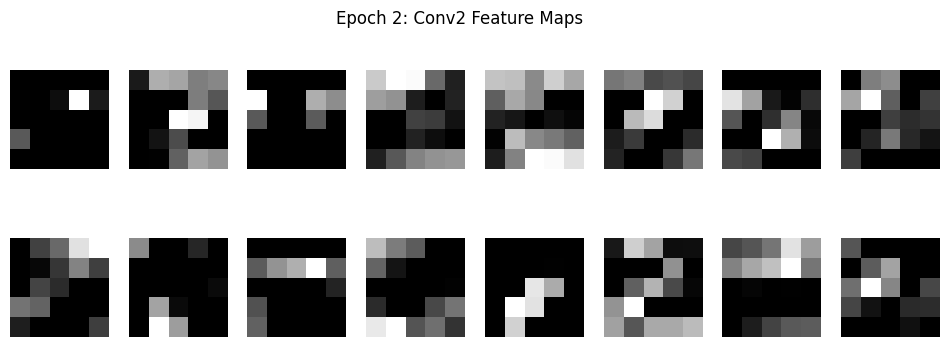

Epoch: 3	Train Loss: 0.0394, Train Acc: 98.78% | Val Loss: 0.0521, Val Acc: 98.45%


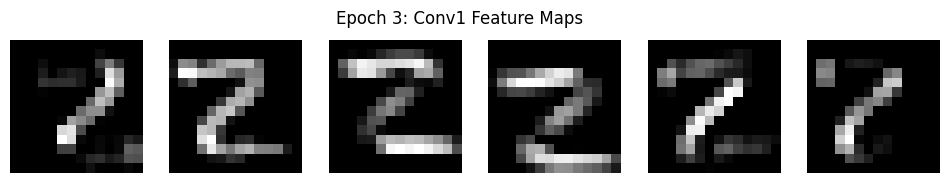

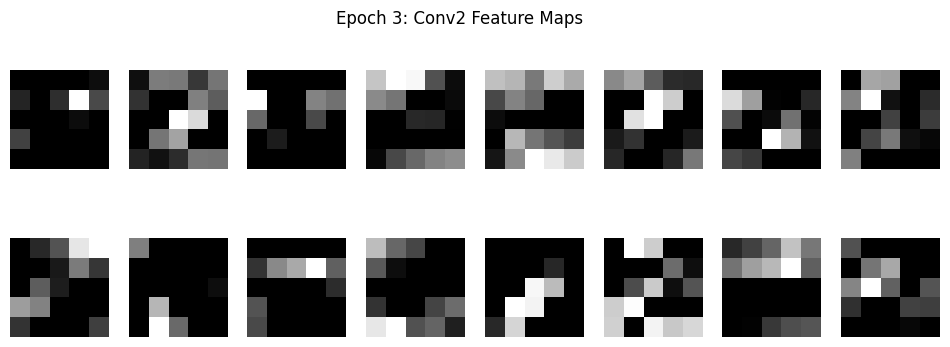

Epoch: 4	Train Loss: 0.0335, Train Acc: 98.87% | Val Loss: 0.0402, Val Acc: 98.86%


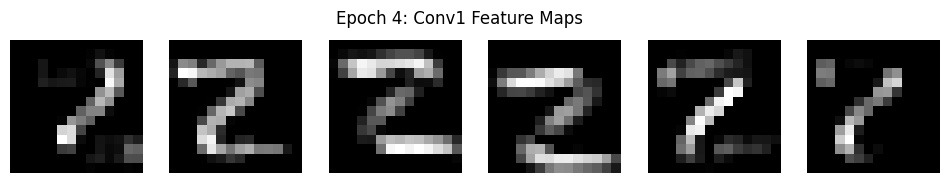

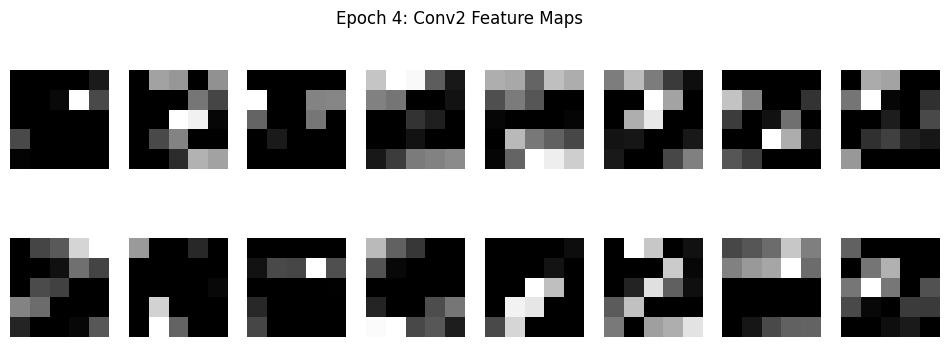

Epoch: 5	Train Loss: 0.0257, Train Acc: 99.20% | Val Loss: 0.0655, Val Acc: 98.18%
개선 없음 - Early Stopping 카운터: 1/10


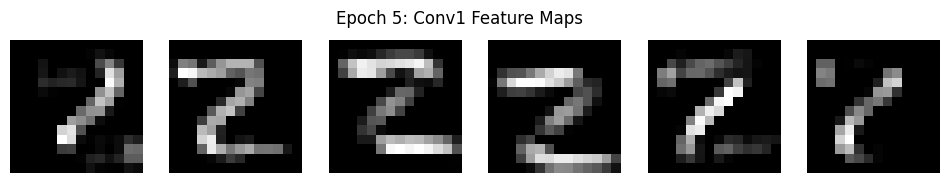

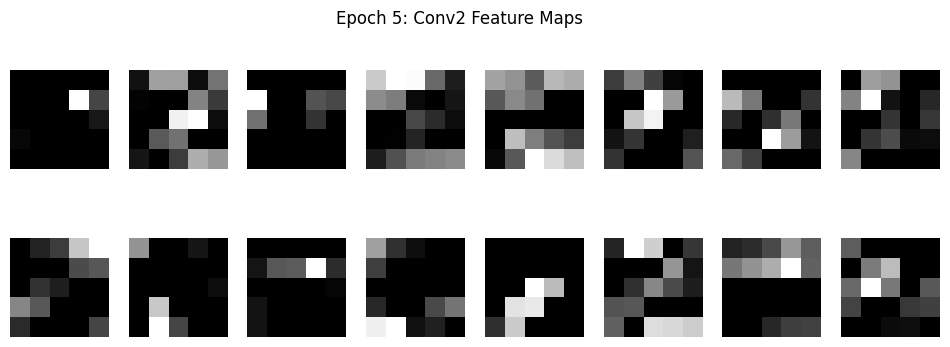

Epoch: 6	Train Loss: 0.0227, Train Acc: 99.24% | Val Loss: 0.0475, Val Acc: 98.74%
개선 없음 - Early Stopping 카운터: 2/10


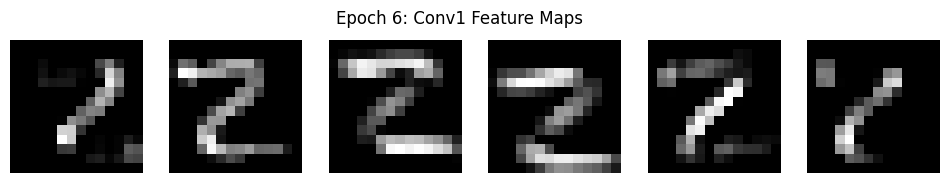

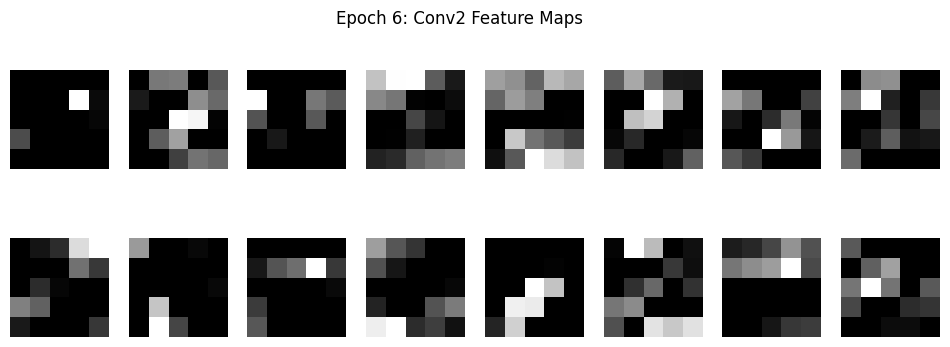

Epoch: 7	Train Loss: 0.0188, Train Acc: 99.39% | Val Loss: 0.0467, Val Acc: 98.78%
개선 없음 - Early Stopping 카운터: 3/10


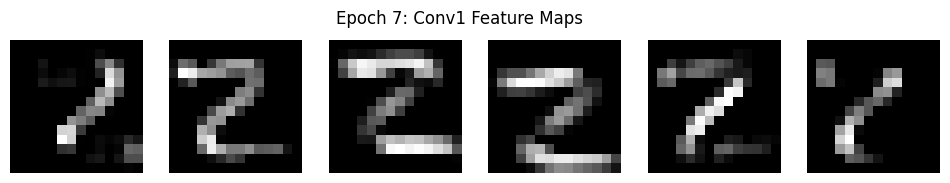

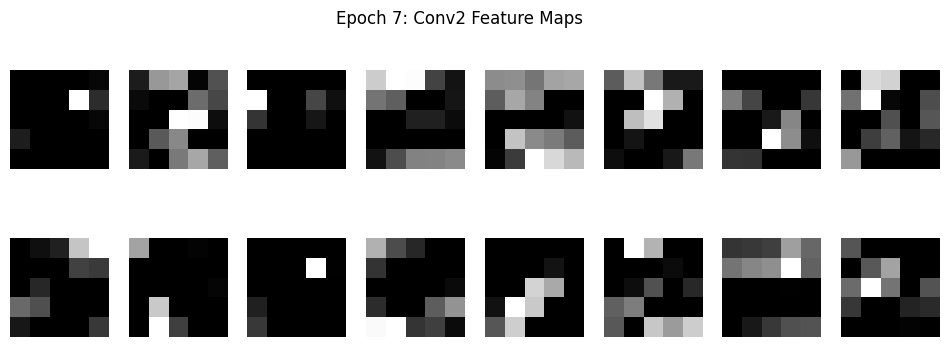

Epoch: 8	Train Loss: 0.0170, Train Acc: 99.44% | Val Loss: 0.0511, Val Acc: 98.76%
개선 없음 - Early Stopping 카운터: 4/10


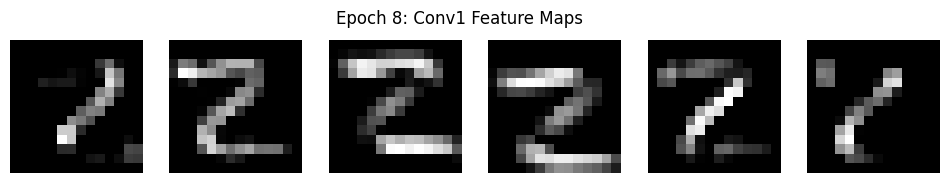

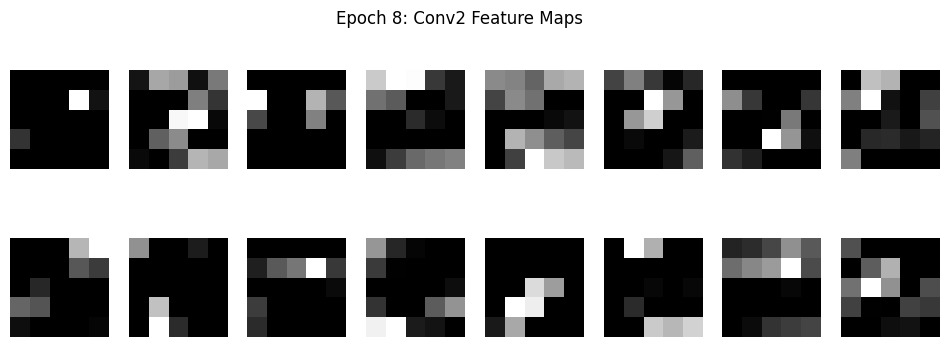

Epoch: 9	Train Loss: 0.0144, Train Acc: 99.56% | Val Loss: 0.0436, Val Acc: 98.79%
개선 없음 - Early Stopping 카운터: 5/10


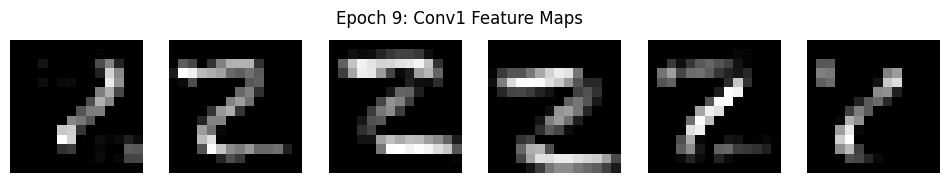

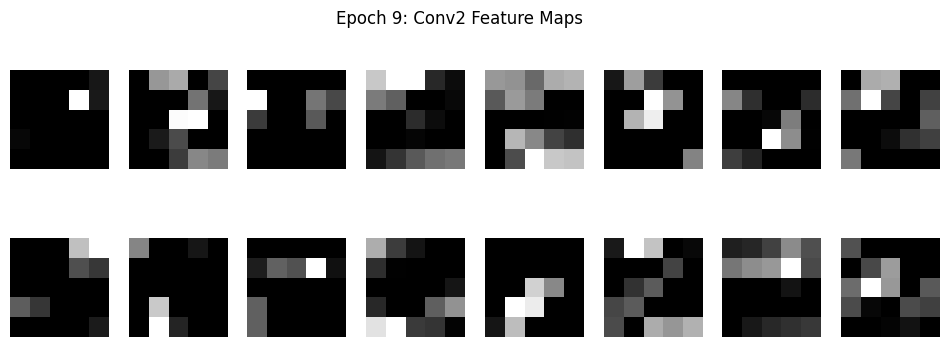

Epoch: 10	Train Loss: 0.0060, Train Acc: 99.83% | Val Loss: 0.0430, Val Acc: 99.00%
개선 없음 - Early Stopping 카운터: 6/10
모델 저장 완료: lenet5_10


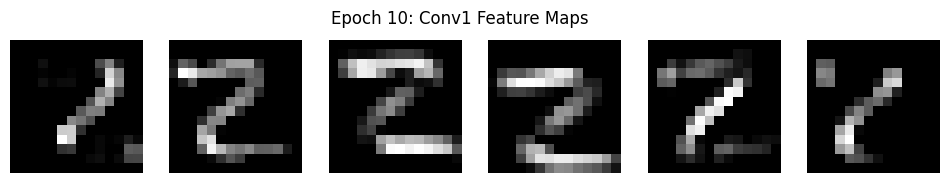

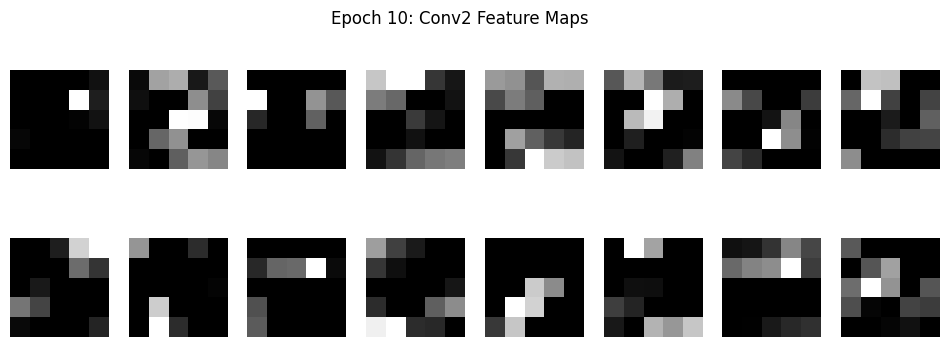

Epoch: 11	Train Loss: 0.0041, Train Acc: 99.89% | Val Loss: 0.0489, Val Acc: 98.96%
개선 없음 - Early Stopping 카운터: 7/10


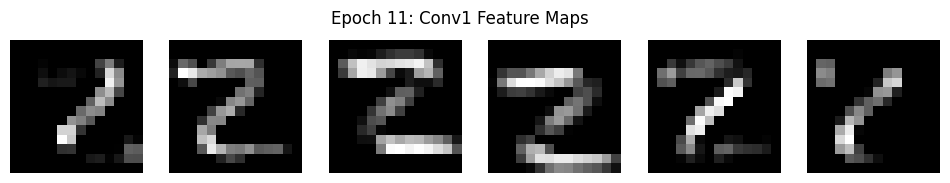

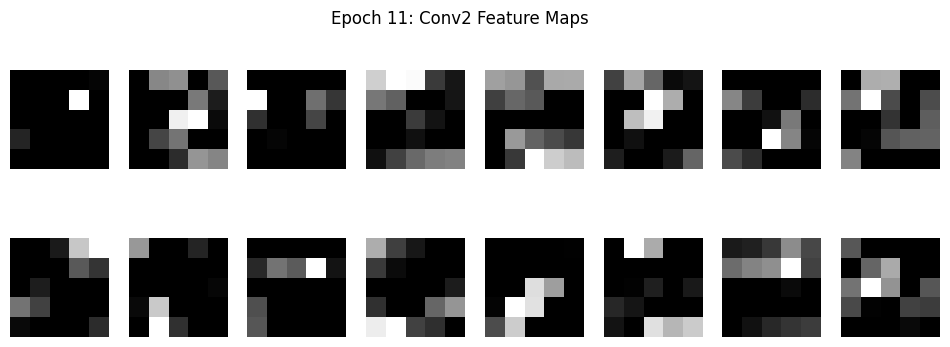

Epoch: 12	Train Loss: 0.0049, Train Acc: 99.85% | Val Loss: 0.0489, Val Acc: 98.92%
개선 없음 - Early Stopping 카운터: 8/10


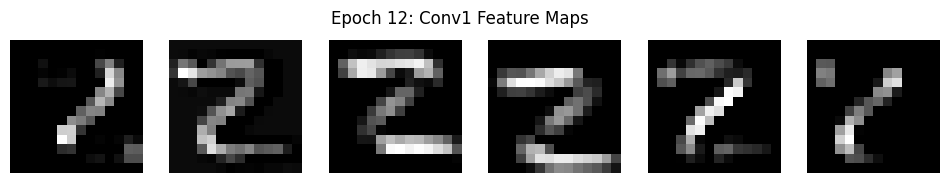

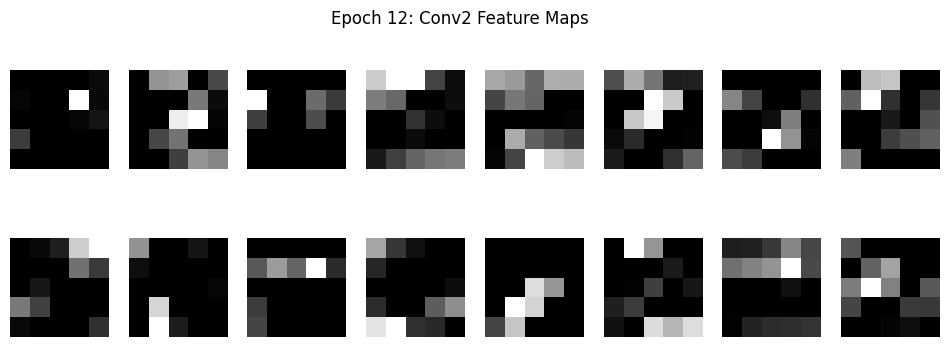

Epoch: 13	Train Loss: 0.0032, Train Acc: 99.90% | Val Loss: 0.0532, Val Acc: 98.99%
개선 없음 - Early Stopping 카운터: 9/10


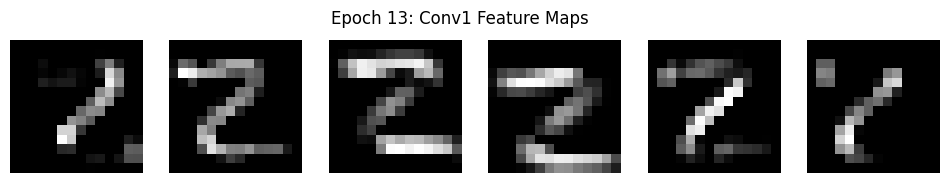

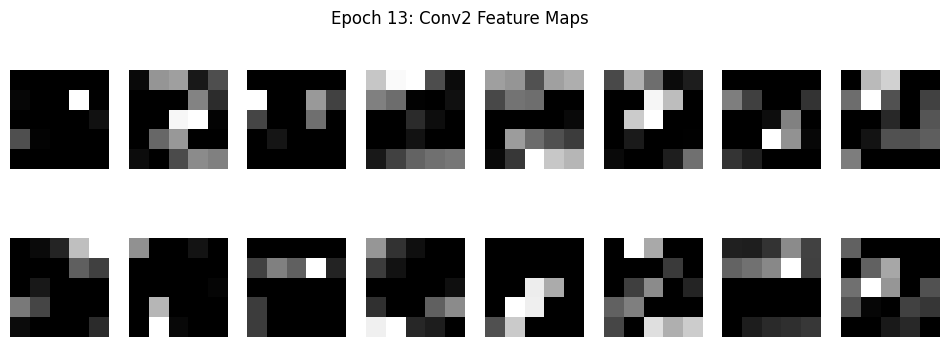

Epoch: 14	Train Loss: 0.0031, Train Acc: 99.90% | Val Loss: 0.0519, Val Acc: 98.98%
개선 없음 - Early Stopping 카운터: 10/10
Early Stopping 조건 충족 - 학습 중단


In [26]:
from torch import optim
import copy  # 모델 가중치 복사를 위한 모듈

# model.load_state_dict(torch.load("lenet5_20.pth"))  # 기존 모델 불러오기
# 하이퍼 파라미터
epochs = 100
patience = 10  # Early Stopping 허용 에폭 수
best_val_loss = float('inf')  # 초기 검증 손실
counter = 0   # Early Stopping 카운터

criterion = nn.CrossEntropyLoss()  # 손실함수
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 최적화 함수
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.5)  # 학습률 스케쥴러


history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}


for epoch in range(epochs):
    ### train
    model.train()
    loss_train = 0.0
    correct, total = 0, 0
    
    for data, target in train_loader:
        # gpu로 보내기
        data, target = data.to(device), target.to(device)
        # data = data.reshape(-1, 32 * 32)  # Flatten
        
        # 학습과정
        optimizer.zero_grad()
        yhat = model(data)
        loss = criterion(yhat, target)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        preds = torch.argmax(yhat, dim=1)  # 정확도 계산
        correct += (preds == target).sum().item()
        total += target.size(0)
    
    train_loss = loss_train / len(train_loader)
    history['train_loss'].append(train_loss)
    
    train_accuracy = 100 * correct / total
    history['train_acc'].append(train_accuracy)
    
    ### validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():  # 역전파 X
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            # data = data.reshape(-1, 32 * 32)

            yhat = model(data)
            loss = criterion(yhat, target)

            val_loss += loss.item()
            preds = torch.argmax(yhat, dim=1)
            val_correct += (preds == target).sum().item()
            val_total += target.size(0)

    val_loss = val_loss / len(val_loader)
    history['val_loss'].append(val_loss)
    
    val_accuracy = 100 * val_correct / val_total
    history['val_acc'].append(val_accuracy)
    
    # 결과 출력
    print(
        f"Epoch: {epoch}\t"
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
    )
    
    # Early Stopping 및 모델 저장
    if val_loss < best_val_loss:  #  성능 개선 확인 (검증 손실 기준)
        best_val_loss = val_loss
        counter = 0  # Early Stopping 카운터 초기화
    else:
        counter += 1
        print(f"개선 없음 - Early Stopping 카운터: {counter}/{patience}")

        if counter >= patience:  # Early Stopping 조건 만족 시 학습 종료
            print("Early Stopping 조건 충족 - 학습 중단")
            break
    
    # 모델 저장
    if epoch % 10 == 0:
        # best_model_wts = copy.deepcopy(model.state_dict())  # 가중치 복사
        model_name = f"lenet5_{epoch}"
        torch.save(model.state_dict(), f'{model_name}.pth')  # 모델 가중치만 저장
        print(f"모델 저장 완료: {model_name}")
        
    # 예측값 그림 그려보기
    with torch.no_grad():
        sample_data = data[:1]  # 배치에서 첫 번째 샘플 선택
        feature_map1, feature_map2 = model.extract_feature(sample_data)  # Feature Map 추출

        # Conv1 Feature Map 시각화
        feature_map1 = feature_map1.cpu().detach().numpy()[0]  # (6, 14, 14)
        fig, axes = plt.subplots(1, 6, figsize=(12, 2))
        for i in range(6):
            axes[i].imshow(feature_map1[i], cmap="gray")
            axes[i].axis("off")
        plt.suptitle(f"Epoch {epoch}: Conv1 Feature Maps")
        plt.show()

        # Conv2 Feature Map 시각화
        feature_map2 = feature_map2.cpu().detach().numpy()[0]  # (16, 5, 5)
        fig, axes = plt.subplots(2, 8, figsize=(12, 4))  # Conv2의 16개 Feature Map
        for i in range(16):
            axes[i // 8, i % 8].imshow(feature_map2[i], cmap="gray")
            axes[i // 8, i % 8].axis("off")
        plt.suptitle(f"Epoch {epoch}: Conv2 Feature Maps")
        plt.show()
        
    scheduler.step()  # 학습률 스케줄링 적용





<Figure size 600x400 with 0 Axes>

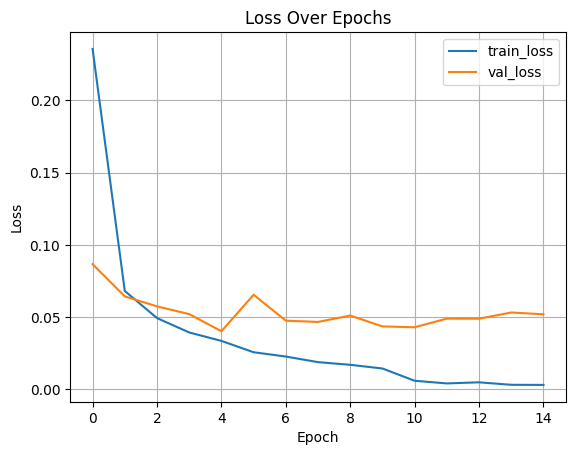

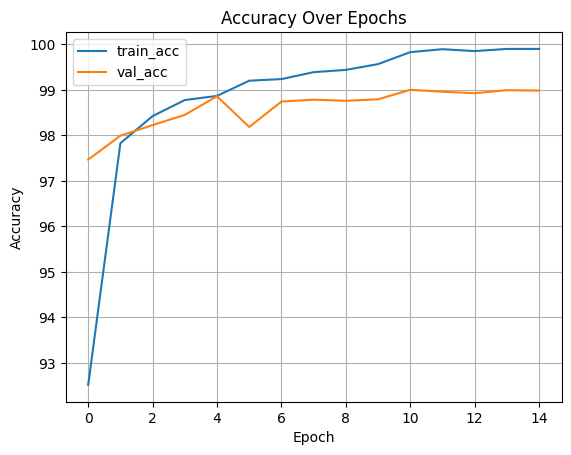

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# 학습 곡선 시각화
plt.figure(figsize=(6, 4))

# Train Loss와 Validation Loss 각각 그리기
loss_data = pd.DataFrame(history)

# loss_data.plot()
loss_data[["train_loss", "val_loss"]].plot()

# 그래프 제목 및 라벨 설정

plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()  # 그리드 추가
plt.show()

loss_data[["train_acc", "val_acc"]].plot()

# 그래프 제목 및 라벨 설정
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()  # 그리드 추가
plt.show()


In [ ]:
# 테스트 평가
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        
        loss = criterion(outputs, target)
        test_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == target).sum().item()
        test_total += target.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0363, Test Accuracy: 99.19%


In [13]:
# model.load_state_dict(torch.load("lenet5_20.pth"))  # 기존 모델 불러오기

<All keys matched successfully>

Test Accuracy: 99.19% (9919 / 10000)


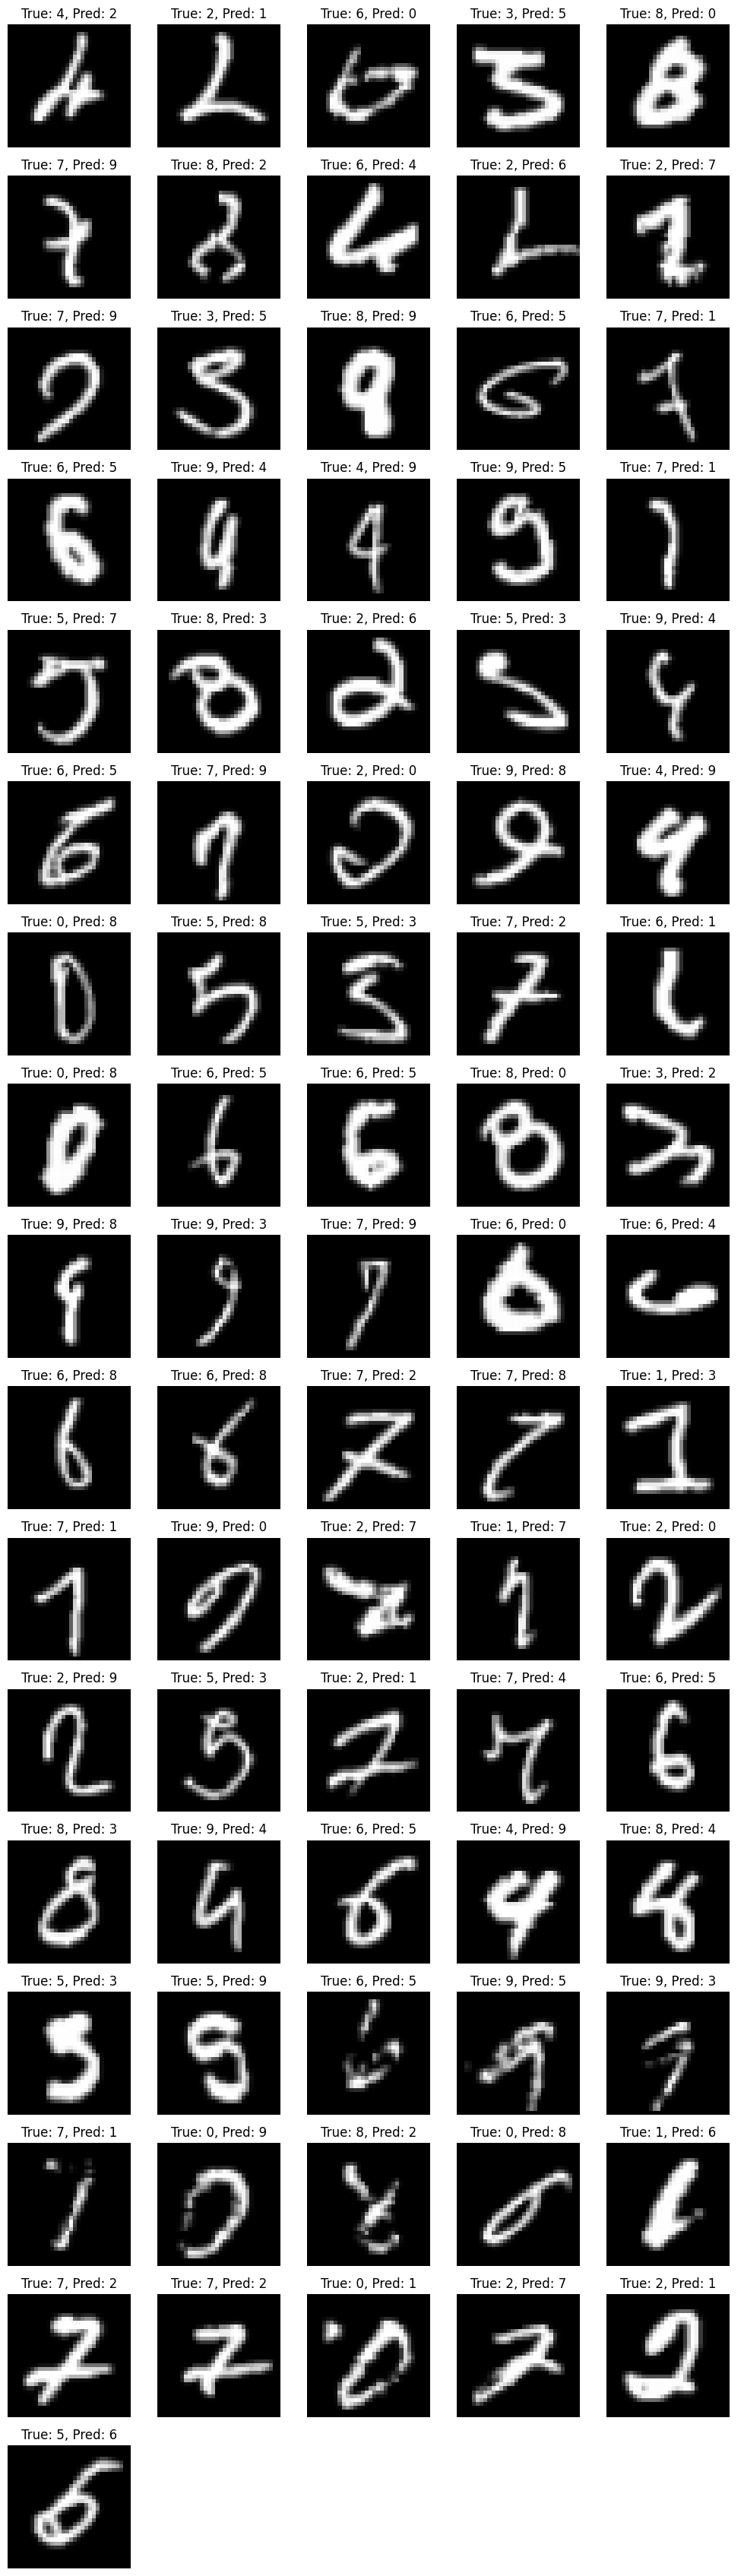

In [40]:
# 데이터 1개 예측값 확인하기
import matplotlib.pyplot as plt

model.eval()

# 잘못된 예측을 저장할 리스트
incorrect_images = []
incorrect_labels = []
incorrect_preds = []
test_correct, test_total = 0, 0
# 예측 수행
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == target).sum().item()
        test_total += target.size(0)

        # 틀린 예측 필터링
        incorrect_mask = (preds != target)
        incorrect_indices = torch.where(incorrect_mask)[0]

        for idx in incorrect_indices:
            incorrect_images.append(data[idx].cpu().numpy().squeeze())  # 이미지 저장
            incorrect_labels.append(target[idx].cpu().item())  # 실제값 저장
            incorrect_preds.append(preds[idx].cpu().item())  # 예측값 저장

# 틀린 그림 출력
num_images = len(incorrect_images)
cols = 5
rows = (num_images // cols) + (1 if num_images % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}% ({test_correct} / {test_total})")

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(incorrect_images[i], cmap="gray")
        ax.set_title(f"True: {incorrect_labels[i]}, Pred: {incorrect_preds[i]}")
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()